<a href="https://colab.research.google.com/github/anujdutt9/Deep-Learning-TF-2.0/blob/master/Train_and_Visualize_Word_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, we'll train a small model for our own word embeddings.

In Deep Learning, the text can be represented using following three methods for training:
  1. **One Hot Encoding**

  In this method, we take the unique words from the text and create a vocabulary. Now using this, we create a zero vector i.e. a vector containing all zeroes of the size of the vocabulary.
  
  Next, for each word in the new sentence, we create a vector containing "1" at the index representing the word while rest all indices remain 0. This step is repeated till we reach the end of the sentence.
  
  Example:
  ```
  Text: "TensorFlow is a great tool to work with."
  Vocabulary:  [a, great, is, TensorFlow, to, tool, with, work]
  zero vector: [0,   0  ,  0,     0    ,   0,   0 ,   0 ,   0 ]

   One hot Encoded Vector for the given string:

                a  great  is  TensorFlow  to  tool  with  work
    a          [1    0    0      0         0    0    0    0  ]
    great      [0    1    0      0         0    0    0    0  ]
    is         [0    0    1      0         0    0    0    0  ]
    TensorFlow [0    0    0      1         0    0    0    0  ]
    to         [0    0    0      0         1    0    0    0  ]
    tool       [0    0    0      0         0    1    0    0  ]
    with       [0    0    0      0         0    0    1    0  ]
    work       [0    0    0      0         0    0    0    1  ]
  ```

    **Cons:**

    The biggest con of using this approach is that this approach is inefficient. You ask how?
    
    If you see the OHE vector above, 99% of the space is taken by 0's and the rest is taken by the 1's i.e. OHE makes up for a sparse matrix. If the neural network is trained on a sparse matrix, half of it's neurons might not even fire up and hence the network will not be able to learn properly.

    Additionally, this approach neglects the fact that how individual word fits into a sentence and has dependence/relation with the words surrounding it.

  We could try and encode each word with a unique number like 5 -> "TensorFlow", 2 -> "great" and so on. Although using this approach is a bit better than OHE in terms of creating a non-sparse matrix but this also suffers for the problem of not capturing the relationship between words in a sentence.

  2. **Word Embeddings**

    In this method, the embeddings are not defined but are learned as part of the model training itself. This way the similar words have similar encodings and relationship of words in a sentence is also captured.

    Let's see this in action.


In [1]:
# Import Dependencies
%tensorflow_version 2.1
import tensorflow as tf
import tensorflow_datasets as tfds

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
# Check TensorFlow Version
tf.__version__

'2.1.0'

In [0]:
# Define the Embedding Layer
# Ref. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
# Set Word Vocabulary Size
vocabulary_size = 1000

# Set Dimension of Output Dense Embeddings per word
embedding_dim = 5

# Define the Embedding layer
embedding_layer = tf.keras.layers.Embedding(input_dim= vocabulary_size, output_dim= embedding_dim)

Right now the Embedding layer has not been the part of the training process. Hence, the weights for the Embedding layer are randomly initialized.

We can pass in a dummy tensor and verify that we are getting the output of the size we have defined above.

In [4]:
# Define a dummy tensor
dummy_tensor = tf.constant([9, 2, 10])

# Pass the dummy tensor to the Embedding Layer
dummy_output = embedding_layer(dummy_tensor)

# Print the outputs of untrained embedding layer for the dummy Inputs by converting to numpy
dummy_output.numpy()

array([[ 0.03273113,  0.01087298, -0.04414312, -0.01499148,  0.01467147],
       [-0.0361277 , -0.02985471,  0.01166075, -0.01669218,  0.0013972 ],
       [ 0.03606255,  0.02322448,  0.00979645,  0.04677153, -0.01995757]],
      dtype=float32)

The embedding layer takes as input a **2D tensor** of shape **(number_of_samples, sequence_length)** where:

**number_of_samples**: the number of rows containing integers representing words from a string

**sequence_length**: number of integers representing words per row

For example:

```
Text1: "Hello World, how are you" => [1, 3, 5, 7, 9]
Text2: "TensorFlow is a great tool" => [2, 4, 6, 8, 10]

input_tensor.shape = [2, 5]

where, 
input_tensor = [[1, 3, 5, 7, 9],
                [2, 4, 6, 8, 10]]

i.e 2 rows of words, 5 words per row.

output_tensor.shape = [2, 5, embedding_size] => [2,5,5]
```

The sequence length can be kept as a fixed number. If the input sentence is shorter than the sequence length, then the input sentence words can be padde with zeroes at the end to match the sequence length.

In [5]:
# Define a dummy tensor of shape [3, 5] i.e. batch of 3 sequences of length 5
dummy_tensor = tf.constant([[9, 2, 10, 35, 23],
                            [5, 35, 90, 12, 4],
                            [1, 3, 6, 2, 9]])

# Pass the dummy tensor to the Embedding Layer
dummy_output = embedding_layer(dummy_tensor)

# Print the outputs of untrained embedding layer for the dummy Inputs by converting to numpy
dummy_output.numpy()

array([[[ 0.03273113,  0.01087298, -0.04414312, -0.01499148,
          0.01467147],
        [-0.0361277 , -0.02985471,  0.01166075, -0.01669218,
          0.0013972 ],
        [ 0.03606255,  0.02322448,  0.00979645,  0.04677153,
         -0.01995757],
        [ 0.0302451 ,  0.04592314,  0.03036597,  0.00663401,
          0.02836991],
        [ 0.00787164, -0.02231135,  0.03355416, -0.04825069,
         -0.04500635]],

       [[ 0.02169379, -0.03128456,  0.00286658,  0.0325079 ,
         -0.04607603],
        [ 0.0302451 ,  0.04592314,  0.03036597,  0.00663401,
          0.02836991],
        [ 0.01876352,  0.04466691, -0.0202319 , -0.02044493,
         -0.01558236],
        [ 0.00777651, -0.01773738,  0.04341805,  0.00456767,
         -0.02359902],
        [ 0.03017494, -0.02905909, -0.02756157, -0.00936361,
          0.03553716]],

       [[ 0.02364678, -0.01963049, -0.0283695 , -0.04931049,
         -0.04370679],
        [ 0.02424895, -0.02760297,  0.01270357, -0.01063126,
         -0

In [6]:
# Check the shape of output tensor => [3, 5, 5]
dummy_output.shape

TensorShape([3, 5, 5])

# Learning Embeddings from Scratch

In this tutorial we'll be training a IMDB sentiment classifier for classifying movie reviews sentiments all while training our word embeddings from scratch.

For this, we'll be using a pre-processed text dataset using **tensorflow_datasets**.

## Loading the Dataset

In [0]:
# Load IMDB Reviews dataset
# Ref. https://www.tensorflow.org/datasets/api_docs/python/tfds/load
(train_data, test_data), info = tfds.load(name='imdb_reviews/subwords8k',
                                          split=(tfds.Split.TRAIN, tfds.Split.TEST),
                                          with_info=True,
                                          as_supervised=True)

## Dataset Evaluation

In [8]:
# Check the dataset
!ls /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0

dataset_info.json
imdb_reviews-test.tfrecord-00000-of-00001
imdb_reviews-train.tfrecord-00000-of-00001
imdb_reviews-unsupervised.tfrecord-00000-of-00001
label.labels.txt
text.text.subwords


So, we can see that we have downloaded the training and test data as TFrecord files as well as dataset info, labels and subwords.

In [9]:
# Check Dataset Info
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [10]:
# Get the Features
info.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

So, we have two labels i.e. pos or neg and the text data with a pre-built **Vocabulary of size 8185**.

In [11]:
# Get Size of Training and Test Data Samples
info.splits

{'test': <tfds.core.SplitInfo num_examples=25000>,
 'train': <tfds.core.SplitInfo num_examples=25000>,
 'unsupervised': <tfds.core.SplitInfo num_examples=50000>}

## Encoding & Decoding Text from Vocabulary

In [12]:
# Check top 20 words in vocabulary
# Ref. https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [13]:
# Test the Encoder
sample_text = "TensorFlow is a great tool."

# Encode the text and print out their index in Vocabulary
ids = encoder.encode(sample_text)
ids

[6307, 2327, 4043, 4265, 9, 4, 122, 411, 8037, 7975]

In [14]:
# Get the words from Index in Vocabulary
text = encoder.decode(ids)
text

'TensorFlow is a great tool.'

## Encoding & Decoding Text from Dataset

In [0]:
# Let's check out a sample movie review
def get_review(data_Split=None):
  data = iter(data_Split)
  sample_review = data.next()
  print("Sample Review [Encoded]: {}\n".format(sample_review))

  # Let's decode this review
  text = encoder.decode(sample_review[0].numpy())
  print("Sample Review [Decoded]: {}\n".format(text))

  # Check Length of review
  print("Review Length: {}".format(len(text)))

In [16]:
# Get First random Review
get_review(data_Split=train_data)

Sample Review [Encoded]: (<tf.Tensor: shape=(163,), dtype=int64, numpy=
array([  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
       5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
          3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
         79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
         33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
         27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
         19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
        102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
          3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
          2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
        102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
         27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
         12,  258, 2306,   13,   91,   29,  171,   5

In [17]:
# Let's check another review and it's length
get_review(data_Split=test_data)

Sample Review [Encoded]: (<tf.Tensor: shape=(283,), dtype=int64, numpy=
array([ 173,   29,  185,   13,  115, 1956, 8044,    3,  398, 1261, 5497,
        423,    2,   15,   18, 4096, 3958,  637, 2657,  552, 2893, 4926,
       2314, 1673, 4587,  137,   23, 4872, 5345,    2, 7996, 7277, 8004,
       8012,  137,   23,  972, 5346, 5977, 1365, 8051,    2, 7998, 3780,
       1947, 1747, 4411, 3743,    3, 5064, 7961,    7,   13, 2671, 4556,
       3449, 1678,  572, 8037, 7968,    8,  604, 1006, 4002, 2618, 7974,
       7994, 7974, 2893, 2618, 7974, 2475, 3912,    3, 4847, 2034, 2615,
         66, 7974, 3201,    2,    5,   20, 1668, 5475, 7961,    5,   20,
       4474,   20,  119,    6,    1, 2489, 1473, 1960,  323,    3,   12,
       1167, 7968,   21, 4101,   14,  366,  342,   12,  284,  552, 7999,
       4949, 3780, 3779, 3369, 8018,  625, 1979,    2,   78, 1259,    2,
         12,  109, 7968,   21,  129,   12, 4101,  236,   14, 1682,  230,
        392,    7, 4980, 1079, 1678,  572, 8037, 796

As we can see that every review has a different length. So, we'll standardize the length of the reviews and pad the reviews with length less than that.

In [0]:
# Load Data in Batches
# Here we set the buffer size to 1000 i.e. at a time we randomly pick up 1000 reviews and fill the buffer with that.
# Then we pick up "N" number of padded samples defined by "padded_batch(batch_size= N)"
# Using "padded_shape = ([None], [])" Pads the data to the smallest per-batch size that fits all elements. 
# Since, the shape of Input is: 'text': Text(shape=(None,), so padded_shape = ([None],[])
# Ref. https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch
train_batches = train_data.shuffle(1000).padded_batch(batch_size= 10, padded_shapes= ([None],[]))
test_batches = test_data.shuffle(1000).padded_batch(batch_size= 10, padded_shapes= ([None],[]))

In [19]:
# Load Batched Training Data and Labels
train_batch, train_labels = next(iter(train_batches))

# Print out one batch of Training Data
train_batch.numpy()

array([[  62,    9,   33, ...,    0,    0,    0],
       [  12,  176,  109, ...,    0,    0,    0],
       [7969, 5321, 7114, ...,    0,    0,    0],
       ...,
       [ 133,  927, 5464, ...,    0,    0,    0],
       [  12,   31,  165, ...,    0,    0,    0],
       [  12,  257,   14, ...,    2, 3568, 7962]])

In [20]:
# Let's check the shape of the training batch and the labels
print("Shape of Single Batch of Training Data: {}\n".format(train_batch.numpy().shape))
print("Shape of Single Batch of Training Labels: {}".format(train_labels.numpy().shape))

Shape of Single Batch of Training Data: (10, 850)

Shape of Single Batch of Training Labels: (10,)


In [21]:
# If you are wondering why the shape is (10, 595), then see.
# 10 => Batch Size, set above in padded_batch
# 595 => coz "padded_shape = ([None], [])" Pads the data to the smallest per-batch size that fits all elements.
# and the length of that batch is as follows
train_batch.numpy()[:-3].shape[1]

850

# Train a simple Bag of Words Model

## Model Architecture

1. The Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

2. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

3. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

4. The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [22]:
# Embedding Dimension
embedding_dim = 16

# Define the Model Architecture
model = tf.keras.Sequential([tf.keras.layers.Embedding(encoder.vocab_size, embedding_dim),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(units=16, activation='relu'),
                             tf.keras.layers.Dense(units=1)
])

# Print Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile the Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
# Train the model
hist = model.fit(train_batches, epochs=10, validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 24s 9ms/step - loss: 0.5039 - accuracy: 0.7013 - val_loss: 0.3748 - val_accuracy: 0.8350
Epoch 2/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.2823 - accuracy: 0.8829 - val_loss: 0.3780 - val_accuracy: 0.8600
Epoch 3/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.2265 - accuracy: 0.9111 - val_loss: 0.2894 - val_accuracy: 0.8550
Epoch 4/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.1921 - accuracy: 0.9276 - val_loss: 0.3205 - val_accuracy: 0.8800
Epoch 5/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1714 - accuracy: 0.9351 - val_loss: 0.3159 - val_accuracy: 0.8700
Epoch 6/10
2500/2500 [==============================] - 17s 7ms/step - loss: 0.1558 - accuracy: 0.9430 - val_loss: 0.3302 - val_accuracy: 0.8700
Epoch 7/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1392 - accuracy: 0.9486 - val_loss: 0.4507 - val_ac

In [0]:
# Save Trained model
model.save('word_embeddings_model.h5')
model.save_weights('word_embeddings_weights.h5')

# Check Model Performance

In [0]:
# Import Dependency
import matplotlib.pyplot as plt

In [29]:
# List all keys available from model training history
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
# Dictionary containing all model training keys
history_dict = hist.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

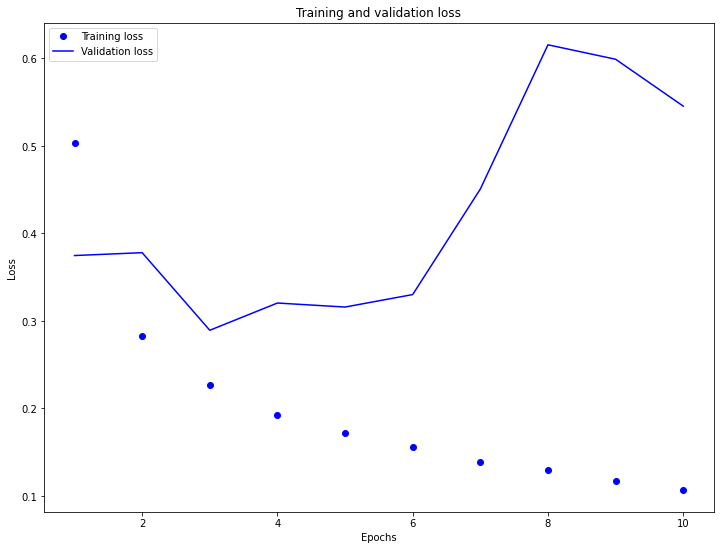

In [31]:
# Plot Training and Validation Loss
plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

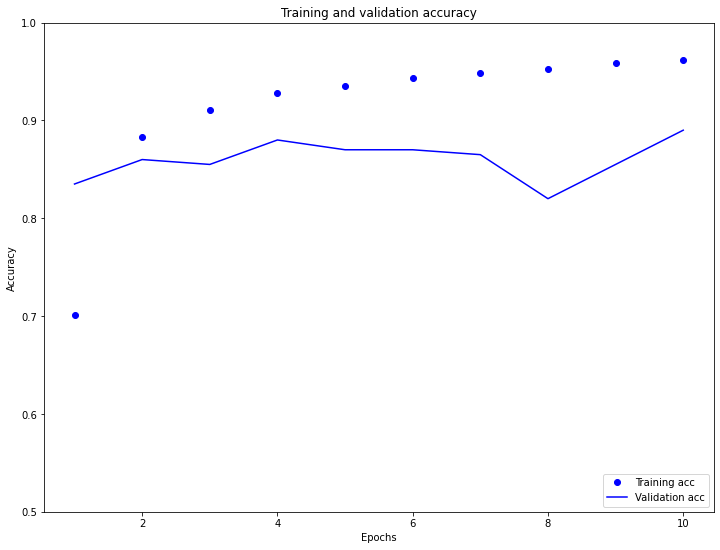

In [32]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

Clearly the model is overfitting.

# Retrieve Learned Embeddings

In [33]:
# The first layer of the model is the trained Model Embeddings
embed_layer = model.layers[0]

# Get Embedding layer weights
embed_weights = embed_layer.get_weights()[0]

# Shape: (vocab_size, embedding_dim)
print(embed_weights.shape) 

(8185, 16)


# Save Word Embeddings

We will now write the weights corresponding to the words in the Vocabulary to disk and visualize them using the "Embedding Projector" tool.

To do this, we will save two files in tab separated format: a file of vectors (containing the embeddings), and a file of meta data (containing the words in vocabulary).

In [0]:
import io

# Define Vocabulary Encoder
encoder = info.features['text'].encoder

# File containing Word Embeddings for words in Vocabulary
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')

# File containing Words in Vocabulary
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  # skip 0, it's padding.
  # Grab all weights corresponding to each word in the Vocabulary
  vec = embed_weights[num+1]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")

# Close Files after writing is done
out_v.close()
out_m.close()

In [0]:
# Download the Saved Files
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')